# Calculating the Big Mac index

This R script shows how _The Economist_ calculates its Big Mac index.

We use the `tidyverse` and `data.table` packages for working with data generally.

In [1]:
library('tidyverse')
library('data.table')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




We only calculate the Big Mac index for certain countries, specifically these ones:

In [2]:
big_mac_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                      'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
                      'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
                      'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
                      'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND', 'VEN',
                      'NIC', 'AZE', 'BHR', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
                      'QAT', 'ROU', 'EUZ')

Our raw data sheet, compiled every six months, contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). We have these data compiled into a single file already, so we can just load it:

In [3]:
big_mac_data = fread('./source-data/big-mac-source-data-v2.csv', na.strings = '#N/A') %>%
    .[!is.na(local_price)] %>%                    # remove lines where the local price is missing
    .[,GDP_local := as.numeric(GDP_local)] %>%    # convert GDP to a number
    .[order(date, name)]                          # sort by date and then by country name, for easy reading
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>
Ukraine,UKR,UAH,120.00,42.0000,5241.316,192143.5,2025-01-01
United Arab Emirates,ARE,AED,18.00,3.6729,48140.644,176796.5,2025-01-01
United States,USA,USD,5.79,1.0000,82715.100,82715.1,2025-01-01
Uruguay,URY,UYU,299.00,43.2700,21656.979,840754.6,2025-01-01
Venezuela,VEN,VES,252.00,56.5814,3737.810,109504.8,2025-01-01
Vietnam,VNM,VND,76000.00,25078.0000,4324.049,101912409.7,2025-01-01


In [4]:
latest_date = big_mac_data$date %>% max
latest_date

[1] "2025-01-01"

### Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [5]:
big_mac_data[, dollar_price := local_price / dollar_ex]
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>
Ukraine,UKR,UAH,120.00,42.0000,5241.316,192143.5,2025-01-01,2.857143
United Arab Emirates,ARE,AED,18.00,3.6729,48140.644,176796.5,2025-01-01,4.900760
United States,USA,USD,5.79,1.0000,82715.100,82715.1,2025-01-01,5.790000
Uruguay,URY,UYU,299.00,43.2700,21656.979,840754.6,2025-01-01,6.910099
Venezuela,VEN,VES,252.00,56.5814,3737.810,109504.8,2025-01-01,4.453760
Vietnam,VNM,VND,76000.00,25078.0000,4324.049,101912409.7,2025-01-01,3.030545


### Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

In [6]:
base_currencies = c('USD', 'EUR', 'GBP', 'JPY', 'CNY')

Calculating the index is as simple as dividing the local price by the price in the base currency. We're using `data.table`'s grouping abilities to do this neatly.

In [7]:
big_mac_index = big_mac_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price)]

for(currency in base_currencies) {
    big_mac_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            dollar_price /          # we divide the dollar price in each row by
                                    # the dollar price on the *base currency*'s row (.SD is a data.table
            .SD[currency_code == currency]$dollar_price -        # that contains only the current group)
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]
tail(big_mac_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD,EUR,GBP,JPY,CNY
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-01-01,UKR,UAH,Ukraine,120.00,42.0000,2.857143,-0.50654,-0.52005,-0.50100,-0.08122,-0.18792
2025-01-01,ARE,AED,United Arab Emirates,18.00,3.6729,4.900760,-0.15358,-0.17675,-0.14409,0.57595,0.39294
2025-01-01,USA,USD,United States,5.79,1.0000,5.790000,0.00000,-0.02737,0.01122,0.86191,0.64569
2025-01-01,URY,UYU,Uruguay,299.00,43.2700,6.910099,0.19345,0.16079,0.20684,1.22210,0.96405
2025-01-01,VEN,VES,Venezuela,252.00,56.5814,4.453760,-0.23078,-0.25184,-0.22215,0.43221,0.26589
2025-01-01,VNM,VND,Vietnam,76000.00,25078.0000,3.030545,-0.47659,-0.49092,-0.47072,-0.02546,-0.13863


We can also see a basic plot, like so:

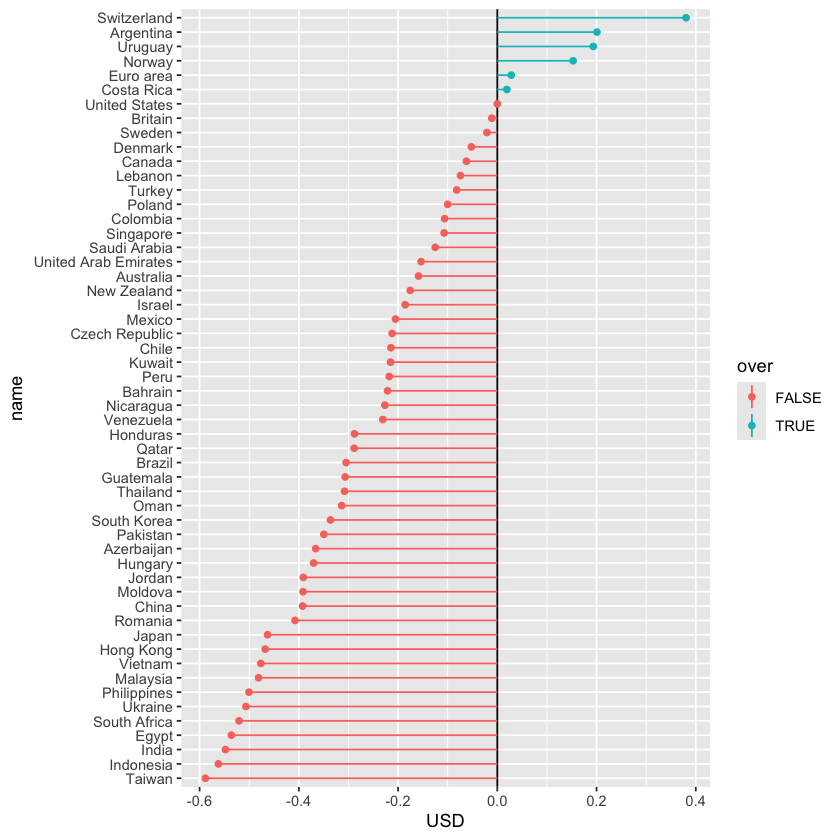

In [8]:
to_plot = big_mac_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

We've now calculated the index. We'll save it to a file.

In [9]:
fwrite(big_mac_index, './output-data/big-mac-raw-index.csv')

Lovely! We've got it. So what about that adjusted index?

## Calculating the adjusted index

While the Big Mac index is a refreshingly simple way of thinking about relative currency values, a common (and fair) objection to it is that burgers cannot be easily traded across borders. Given non-traded local inputs (rent and worker’s wages) one would expect Big Macs to be cheaper in poorer countries and dearer in wealthier ones.

We'll start out by only picking the countries where we have GDP data.

In [10]:
big_mac_gdp_data = big_mac_data[GDP_local > 0]
head(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>
Argentina,ARG,ARS,2.50,1.0000000,9283.175,9283.175,2000-04-01,2.500000
Australia,AUS,AUD,2.59,1.6800000,20394.027,32402.454,2000-04-01,1.541667
Brazil,BRA,BRL,2.95,1.7900000,5123.549,5941.865,2000-04-01,1.648045
Britain,GBR,GBP,1.90,0.6329114,28283.064,17075.690,2000-04-01,3.002000
Canada,CAN,CAD,2.85,1.4700000,21046.556,31222.677,2000-04-01,1.938776
Chile,CHL,CLP,1260.00,514.0000000,5475.546,2520325.547,2000-04-01,2.451362


In order to correct for the problem, we'll use a linear regression of GDP vs Big Mac Price.

We sometimes add or remove countries from the Big Mac index, but we want the list of countries on which we base the adjusted index to remain consistent. We use this list of countries to calculate the relationship between GDP and Big Mac price.

In [11]:
regression_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                         'EGY', 'EUZ', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX',
                         'NZL', 'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF',
                         'KOR', 'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'USA', 'COL', 'PAK',
                         'IND', 'AUT', 'BEL', 'NLD', 'FIN', 'FRA', 'DEU', 'IRL', 'ITA',
                         'PRT', 'ESP', 'GRC', 'EST')
# in 2021, we added a number of additional countries to the adjusted index
regression_addons_2021 = c('ARE', 'CRI', 'LKA', 'UKR', 'URY', 'VNM', 'GTM', 'HND', 'NIC',
                           'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'MDA', 'OMN', 'QAT', 'ROU',
                           'SVK', 'SVN', 'LVA', 'LTU')
big_mac_gdp_data = big_mac_gdp_data[iso_a3 %in% regression_countries |
  (iso_a3 %in% regression_addons_2021 & date >= as.Date('2021-01-01'))
]

tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>
Turkey,TUR,TRY,190.00,35.74025,13235.882,310941.8,2025-01-01,5.316135
Ukraine,UKR,UAH,120.00,42.00000,5241.316,192143.5,2025-01-01,2.857143
United Arab Emirates,ARE,AED,18.00,3.67290,48140.644,176796.5,2025-01-01,4.900760
United States,USA,USD,5.79,1.00000,82715.100,82715.1,2025-01-01,5.790000
Uruguay,URY,UYU,299.00,43.27000,21656.979,840754.6,2025-01-01,6.910099
Vietnam,VNM,VND,76000.00,25078.00000,4324.049,101912409.7,2025-01-01,3.030545


We create a new "Big-Mac-adjusted per-capita GDP", which is the GDP in local currency, divided by the exchange rate as determined by Big Macs (that is, the price in local currency divided by the price in the United States). This performs a similar function to "purchasing-power parity" adjustments, but using only the price of a Big Mac to make the adjustment.

In [12]:
big_mac_gdp_data %>%
    .[,GDP_bigmac := GDP_local / (local_price / .SD[iso_a3=='USA']$local_price), by=date]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>
Turkey,TUR,TRY,190.00,35.74025,13235.882,310941.8,2025-01-01,5.316135,9475.542
Ukraine,UKR,UAH,120.00,42.00000,5241.316,192143.5,2025-01-01,2.857143,9270.924
United Arab Emirates,ARE,AED,18.00,3.67290,48140.644,176796.5,2025-01-01,4.900760,56869.546
United States,USA,USD,5.79,1.00000,82715.100,82715.1,2025-01-01,5.790000,82715.100
Uruguay,URY,UYU,299.00,43.27000,21656.979,840754.6,2025-01-01,6.910099,16280.834
Vietnam,VNM,VND,76000.00,25078.00000,4324.049,101912409.7,2025-01-01,3.030545,7764.116


Now that we have our consistent basket of "regression countries", we can run our regressions. We can see what that looks like:

`geom_smooth()` using formula = 'y ~ x'


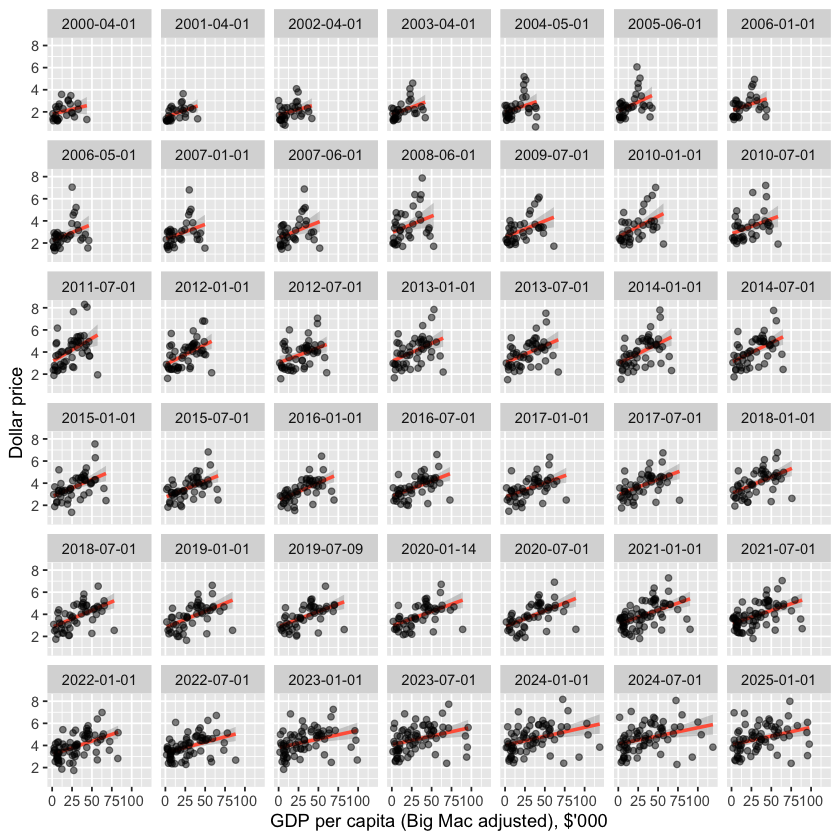

In [13]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date)+
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

We have to calculate the regressions separately for each date (ggplot did this for us above).

In [14]:
big_mac_gdp_data[date=='2022-07-01']

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>
Argentina,ARG,ARS,590.00,129.115000,8489.332,599642.029,2022-07-01,4.569570,5234.163
Australia,AUS,AUD,6.70,1.448436,53249.731,77126.304,2022-07-01,4.625680,59283.652
Austria,AUT,EUR,4.35,0.975850,48837.350,42791.664,2022-07-01,4.457652,50661.395
Azerbaijan,AZE,AZN,4.70,1.698250,4280.429,7276.729,2022-07-01,2.767555,7973.437
Bahrain,BHR,BHD,1.60,0.377000,24342.844,9152.910,2022-07-01,4.244032,29460.929
Belgium,BEL,EUR,4.60,0.975850,45615.359,39968.531,2022-07-01,4.713839,44747.377
Brazil,BRA,BRL,22.90,5.391750,7057.072,36380.853,2022-07-01,4.247230,8181.720
Britain,GBR,GBP,3.69,0.831080,40230.545,31357.404,2022-07-01,4.440006,43764.399
Canada,CAN,CAD,5.88,1.289150,43573.195,58438.307,2022-07-01,4.561145,51183.211


In [15]:
big_mac_gdp_data[
    ,
    `:=`(
        adj_price=lm(dollar_price ~ GDP_bigmac) %>% predict
#         adj_price_USD=lm(dollar_price ~ GDP_dollar) %>% predict
    ),
    by = date]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>,<dbl>
Turkey,TUR,TRY,190.00,35.74025,13235.882,310941.8,2025-01-01,5.316135,9475.542,4.211375
Ukraine,UKR,UAH,120.00,42.00000,5241.316,192143.5,2025-01-01,2.857143,9270.924,4.208144
United Arab Emirates,ARE,AED,18.00,3.67290,48140.644,176796.5,2025-01-01,4.900760,56869.546,4.959792
United States,USA,USD,5.79,1.00000,82715.100,82715.1,2025-01-01,5.790000,82715.100,5.367929
Uruguay,URY,UYU,299.00,43.27000,21656.979,840754.6,2025-01-01,6.910099,16280.834,4.318840
Vietnam,VNM,VND,76000.00,25078.00000,4324.049,101912409.7,2025-01-01,3.030545,7764.116,4.184349


If we've done everything right, all the points we just generated should be on those lines from above...

`geom_smooth()` using formula = 'y ~ x'


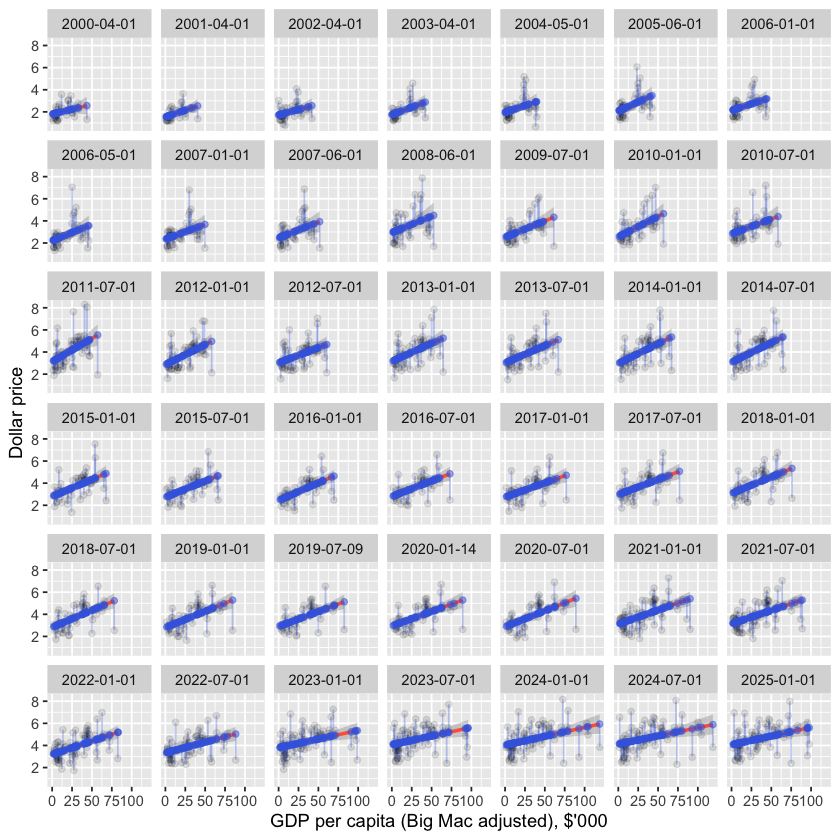

In [16]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_linerange(aes(ymin=dollar_price, ymax=adj_price), color='royalblue', alpha=0.3) +
    geom_point(alpha=0.1) +
    geom_point(aes(y=adj_price), color='royalblue', alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

Yep, that's exactly what we wanted. So now that we've got these data, we can do almost the same thing as before.

In [17]:
big_mac_adj_index = big_mac_gdp_data[
    !is.na(dollar_price) &
    (
        iso_a3 %in% regression_countries |
        iso_a3 %in% regression_addons_2021 & date >= '2021-01-01'
    ) &
    iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price, GDP_bigmac, adj_price)]

for(currency in base_currencies) {
    big_mac_adj_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            (                       # we divide the dollar price by the adjusted price to get
                dollar_price / adj_price  # the deviation from our expectation by
            ) /
                                    # the same figure from the *base currency*'s rowa\
            (
                .SD[currency_code == currency]$dollar_price /
                .SD[currency_code == currency]$adj_price
            ) -
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_adj_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]

tail(big_mac_adj_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_bigmac,adj_price,USD,EUR,GBP,JPY,CNY
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-01-01,TUR,TRY,Turkey,190.00,35.74025,5.316135,9475.542,4.211375,0.17031,0.00488,0.07082,1.01704,0.57212
2025-01-01,UKR,UAH,Ukraine,120.00,42.00000,2.857143,9270.924,4.208144,-0.37054,-0.45952,-0.42405,0.08488,-0.15442
2025-01-01,ARE,AED,United Arab Emirates,18.00,3.67290,4.900760,56869.546,4.959792,-0.08393,-0.21342,-0.16181,0.57885,0.23059
2025-01-01,USA,USD,United States,5.79,1.00000,5.790000,82715.100,5.367929,0.00000,-0.14136,-0.08501,0.72351,0.34334
2025-01-01,URY,UYU,Uruguay,299.00,43.27000,6.910099,16280.834,4.318840,0.48336,0.27367,0.35726,1.55658,0.99265
2025-01-01,VNM,VND,Vietnam,76000.00,25078.00000,3.030545,7764.116,4.184349,-0.32854,-0.42345,-0.38562,0.15727,-0.09800


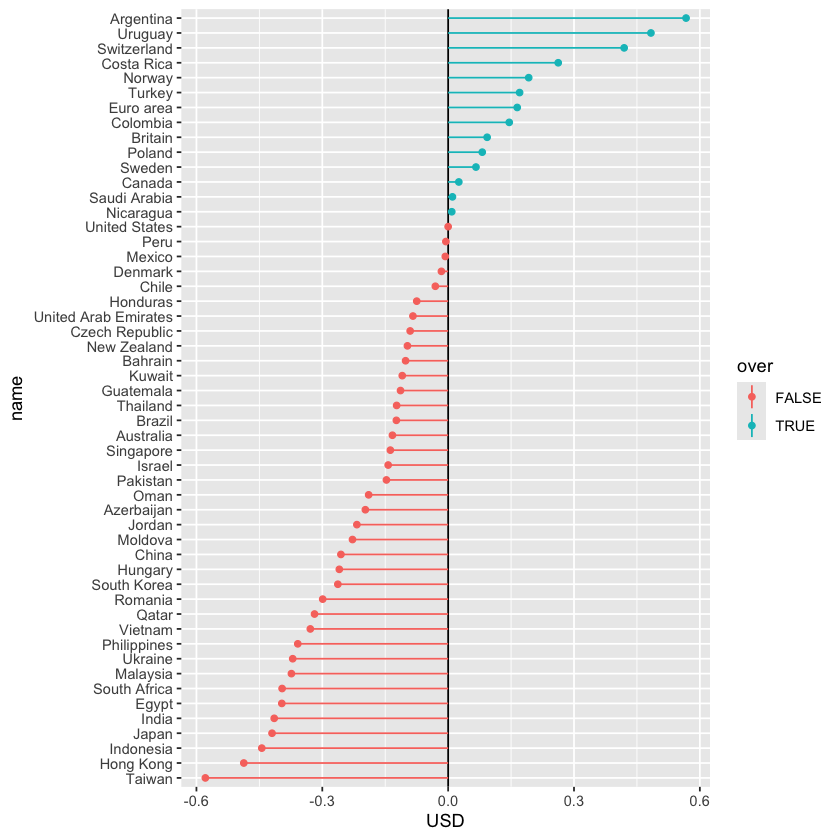

In [18]:
to_plot = big_mac_adj_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

In [19]:
fwrite(big_mac_adj_index, './output-data/big-mac-adjusted-index.csv')

Also, for tidiness, we'll generate a consolidated file with both indices in one table.

In [20]:
big_mac_full_index = merge(big_mac_index, big_mac_adj_index,
      by=c('date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price'),
      suffixes=c('_raw', '_adjusted'),
      all.x=TRUE
     )
tail(big_mac_full_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_bigmac,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-01-01,UKR,UAH,Ukraine,120.00,42.0000,2.857143,-0.50654,-0.52005,-0.50100,-0.08122,-0.18792,9270.924,4.208144,-0.37054,-0.45952,-0.42405,0.08488,-0.15442
2025-01-01,URY,UYU,Uruguay,299.00,43.2700,6.910099,0.19345,0.16079,0.20684,1.22210,0.96405,16280.834,4.318840,0.48336,0.27367,0.35726,1.55658,0.99265
2025-01-01,USA,USD,United States,5.79,1.0000,5.790000,0.00000,-0.02737,0.01122,0.86191,0.64569,82715.100,5.367929,0.00000,-0.14136,-0.08501,0.72351,0.34334
2025-01-01,VEN,VES,Venezuela,252.00,56.5814,4.453760,-0.23078,-0.25184,-0.22215,0.43221,0.26589,NA,NA,NA,NA,NA,NA,NA
2025-01-01,VNM,VND,Vietnam,76000.00,25078.0000,3.030545,-0.47659,-0.49092,-0.47072,-0.02546,-0.13863,7764.116,4.184349,-0.32854,-0.42345,-0.38562,0.15727,-0.09800
2025-01-01,ZAF,ZAR,South Africa,51.90,18.6913,2.776693,-0.52043,-0.53356,-0.51505,-0.10709,-0.21078,12583.468,4.260454,-0.39577,-0.48119,-0.44714,0.04139,-0.18832


In [21]:
fwrite(big_mac_full_index, './output-data/big-mac-full-index.csv')